# Lorenz 96 equation
For a number of variables $ J \in \mathbb{N} $, external force $ F \in \mathbb{R} $ and state variable $ \mathbb{u} \in \mathbb{R}^J $ on 1D periodic domain, the Lorenz 96 equation (Lorenz 1996) is given by

$$ \frac {du^{i}}{dt} =(u^{i+1}-u^{i-2})u^{i-1}-u^{i}+F, $$

with $ u^{-1} = u^{J-1} $, $ u^0 = u^J $, and $ u^{J+1} = u^1 $.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from da.l96 import lorenz96
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.etkf import ETKF
import visualize

data_dir = "data_thesis"

In [15]:
# Parameters for model dynamics
# J: Dim of state space
J = 40

# F: Forcing
F = 8


### Attractor

In [ ]:
# -------------
# Generate data
# -------------

# dt: time step size. 0.2 ~ 1d
dt = 0.01

# N: number of time step, 2 years : 20*360*2
N0 = 360*20 # Number of steps for spin up
N = 360*20

# obs_per: Observation step interval -> observation interval = obs_per * dt
obs_per = 12

# Initial state near the stationary point
x0 = F*np.ones(J) # the stationary point
x0[19] *= 1.001 # perturb

# Use my modules
scheme = rk4
p = (F, )

x_result = np.zeros((N0+N,len(x0)))
x = x0
x_result[0] = x[:]

for n in range(1,N0+N):
    t = n*dt
    x = scheme(lorenz96, t, x, p, dt)
    x_result[n] = x[:]


# Sample per 5
x_true_full = x_result[N0:]
x_true = x_true_full[::obs_per] # spin up 1 year and save per 6 hours
# np.save(f"{data_dir}/x_true_l96", x_true)

## Plot

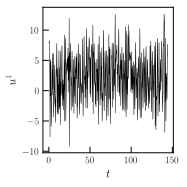

In [17]:
# Plot a single component
i = 0 # Index of the component
u = x_result[:, i]
t = np.arange(N0+N) * dt
fig0, ax0 = plt.subplots(figsize=(3,3))
ax0.grid(False)
ax0.set_xlabel('$ t $')
ax0.set_ylabel('$u^{' + f'{i+1}' + '}$')
ax0.plot(t, u, color="black")
fig0.tight_layout()

# Save figure
fig0.savefig(f"{data_dir}/l96_t-u{i+1}.pdf", transparent=True)

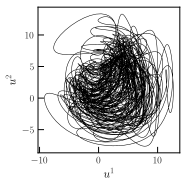

In [18]:
# Plot two components

i1 = 0
i2 = 1
u1 = x_result[:, i1]
u2 = x_result[:, i2]
fig1, ax1 = plt.subplots(figsize=(3,3))
ax1.grid(False)
ax1.set_xlabel('$u^{' + f'{i1+1}' + '}$')
ax1.set_ylabel('$u^{' + f'{i2+1}' + '}$')
ax1.plot(u1, u2, color="black")
fig1.tight_layout()

# Save figure
fig1.savefig(f"{data_dir}/l96_u{i1+1}-u{i2+1}.pdf", transparent=True)

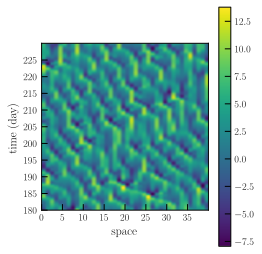

In [19]:
# Hovmollor diagram
day = 50
Z = x_result[N0:N0 + day*20, :]

fig2, ax2 = plt.subplots(figsize=(4,4))
ax2.grid(False)
ax2.set_xlabel('space')
ax2.set_ylabel('time (day)')
ax2.set_xticks(np.arange(0,40,5))
ax2.set_yticks(np.arange(0, day*20, 20*5))
ax2.set_yticklabels(np.arange(180, 180+ day, 5))
im = ax2.imshow(Z, aspect=40/(day*20), extent=[0, 40, 0, day*20], vmax=Z.max(), vmin=Z.min(), origin="lower")
fig2.colorbar(im, )
fig2.tight_layout()
# ax3.set_title('Hovmollor diagram')

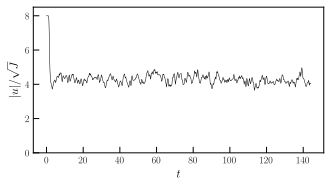

In [20]:
# Norm (normalized energy)
norm = np.linalg.norm(x_result[:], axis=-1)/np.sqrt(J)
t = np.arange(N0+N)*dt
fig3, ax3 = plt.subplots()
ax3.grid(False)
ax3.set_xlabel('$t$')
ax3.set_ylabel('$ |u|/\\sqrt{J}$')
ax3.set_ylim([0.0, 8.5])
ax3.plot(t, norm, color="black")
fig3.tight_layout()
fig3.savefig(f"{data_dir}/l96_norm.pdf")

## Error growth

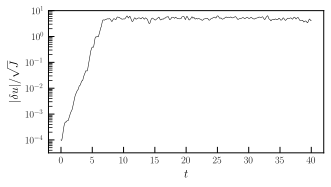

In [21]:
# Attractor
x_atr = x_true_full
N_atr = len(x_atr)

# Parameters for model dynamics
F = 8

# Dt: Time step size, different from dt in general
Dt = 0.01

# N_step: Number of steps
N_step = 4000

# N_atr_sample: Number of initial states from the attractor
# N_atr_sample = len(x_atr)//(2*N_step)
N_atr_sample = 1

# N_noise_sample: Number of added noises to each initial state
N_noise_sample = 1

# epsilon: Amplitude of perturbations
epsilon = 10**(-4)

error = np.zeros((N_atr_sample, N_step))
np.random.seed(1)

for m in range(N_atr_sample):
    z0 = x_atr[m*N_atr//N_atr_sample, :]
    z = np.zeros((N_step, J))
    z[0] = z0
    
    temp_error = np.zeros((N_noise_sample, N_step))
    
    for i in range(N_noise_sample):
        z_perturb = z[0] + epsilon*np.random.normal(size=z[0].shape)
        if N_noise_sample == 1:
            z_perturb = z[0] + epsilon*np.ones(J)
        temp_error[i, 0] = np.linalg.norm(z[0] - z_perturb, ord=2)/np.sqrt(J)
    
        for n in range(1, N_step):
            t = n*Dt
            if i == 0:
                z[n] = rk4(lorenz96, t, z[n-1], p, Dt)
            z_perturb = rk4(lorenz96, t, z_perturb, p, Dt)
            temp_error[i, n] = np.linalg.norm(z[n] - z_perturb, ord=2)/np.sqrt(J)
            
    error[m] = temp_error.mean(axis=0)[:]

error_mean = error.mean(axis=0)

# Plot
# beta = 2.5
n = np.arange(len(error_mean))
t = Dt*n
fig4, ax4 = plt.subplots()
ax4.plot(t, error_mean, color="black")
# ax4.plot(np.exp(beta*n*dt)[:75], lw=1, c="r", ls="--")
ax4.set_yscale("log")
ax4.set_ylabel("$|\\delta u|/\\sqrt{J}$")
ax4.set_xlabel("$ t $")
ax4.set_ylim([10**(-4.5), 10])
# ax4.set_axis_off()
fig4.tight_layout()
fig4.savefig(f"{data_dir}/l96_error_development.pdf", transparent=True)